<a href="https://colab.research.google.com/github/mequanent/Social-Networks/blob/main/SN_Link_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mequanent Argaw Muluneh** \
**Social Networks Homework from Lab2 (Link Prediction)** \

**December 2022**

In [5]:
#@title Import Libraries
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
import tensorflow as tf
import pydot
import time
%matplotlib inline

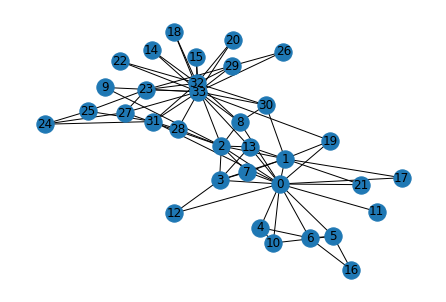

In [95]:
#@title Load the graph
G = nx.karate_club_graph()

# visualize the graph
nx.draw(G, with_labels = True)

In [28]:
#@title Some Graph Descriptions
print("Total No. of nodes: ", G.number_of_nodes()) 
print("Total No. of edges: ", G.number_of_edges())
print(list(nx.nodes(G))) # list of nodes
print(list(G.neighbors(0))) # list of neighbors of a node, 0 for showcase

Total No. of nodes:  34
Total No. of edges:  78
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 17, 19, 21, 31]


# Lab Practice

## Similarity Coefficients 

In [9]:
#@title Local Clustering Coefficient 

# Addition is used in the local clustering 
def get_LCC(g):
  LCC = dict()
  for i in g.nodes:
    triangles = nx.triangles(g, i)
    k = nx.degree(g, i)
    lcc = 0
    if k > 1:
      lcc = (2* triangles) /(k*(k-1))
    LCC[i] = lcc

  lccs = []
  for u in g.nodes:
    for v in g.nodes:
      if u not in nx.neighbors(g, v) and u < v:
        lccs.append((u, v, LCC[u] + LCC[v])) 
  
  return lccs 

In [89]:
#@title SimRank

# get count of neighbors for a node for |I(a)| and |I(b)|
def num_neighbors(g, a):
  neighbors = [i for i in g.neighbors(a)]
  return len(neighbors)

# find the sum of the similarity of neighbors of a and b 
def sim(g, a, b, s):
  sum = 0
  for i in g.neighbors(a):
    for j in g.neighbors(b):
      sum += s[i, j] 
  return sum 

def simRnk(g):
  K = 5 
  C = 0.8 
  
  n = len(g.nodes) # number of nodes
  # first initialize all simiarity values to zero
  S = np.zeros((n, n), np.float16) # S -> nxn similarity matrix
  # then set S(a, b) = 1 for a == b
  np.fill_diagonal(S, 1.0) 

  for k in range(1, K): # S_0(a, b) is already initialized 
    s = S # keep the previous similarity matrix to use for the next
    for a in range(n): 
      I_a = num_neighbors(g, a) 
      for b in range(n): 
        I_b = num_neighbors(g, b) 
        if a == b:
          #S[a, b], S[b, a] = 1.0, 1.0
          S[a, b] = 1.0
        elif I_a == 0 or I_b == 0: # avoid division by zero 
            S[a, b] = 0 
        else:
          S[a, b] = C  * sim(g, a, b, s)/ (I_a*I_b) 
          #simR[b, a] = simR[a, b] 
  return S  

def simRank(g):
  simR = simRnk(g)
  simRanks = []
  for u in g.nodes:
    for v in g.nodes:
      if u not in nx.neighbors(g, v) and u < v:
        simRanks.append((u, v, simR[u, v])) 
  
  return simRanks 

## Sort the coefficients 

In [7]:
#@title Edges removing function 

# This code has changed from the lab to make it function for later use
def remove_edges(graph, edgelist):
  # sort the edges to be removed in descending order
  edgelist = sorted(edgelist, reverse=True) 
  removed_edges = list()
  for i in edgelist:
      u = list(graph.edges)[i][0]
      v = list(graph.edges)[i][1]
      removed_edges.append([u,v])
      graph.remove_edge(u,v)
  return removed_edges

In [99]:
edge_to_remove = [75, 51, 18]
removed_edges = remove_edges(G, edge_to_remove)
k = len(removed_edges)

In [8]:
#@title Descending sort

# to avoid the same statement for all similarity coefficients 
def sort_coef(coefficient):
  return sorted(coefficient, key=lambda tup: tup[2], reverse=True)

In [100]:
#@title Get the coefficients and sort them

#@title cn, jaccard, pref_attachment, adamic 
cn = nx.common_neighbor_centrality(G) # common neighbor 
jaccard = nx.jaccard_coefficient(G) 
pref_attachment = nx.preferential_attachment(G) 
adamic = nx.adamic_adar_index(G) 
lccs =  get_LCC(G) 
simRanks = simRank(G) 
#simRanks = nx.simrank_similarity(G, source=None, target=None,
#                                 importance_factor=0.8, max_iterations=5)
#simRanks = nx.simrank_similarity(G, importance_factor=0.8)

# sort the coefficients 
cn = sort_coef(cn)
jaccard = sort_coef(jaccard)
adamic = sort_coef(adamic)
pref_attachment = sort_coef(pref_attachment)
lccs= sort_coef(lccs)
simRanks = sort_coef(simRanks)

## Evaluation Metrics

In [11]:
#@title Mean Rank (MR)
def MR(sorted_tuple, removed_edges):
  rank_cn = 0
  idx = 0
  for u,v,val in sorted_tuple:
      if [u,v] in removed_edges:
          rank_cn += idx
      idx += 1
  return rank_cn/k

In [12]:
#@title Mean Reciprocal Rank (MRR)
def MRR(sorted_tuple, removed_edges):
  rank_cn = 0
  idx = 0
  for u,v,val in sorted_tuple:
      if [u,v] in removed_edges:
          rank_cn += 1/(idx+1) # 1/(idx +1)
      idx += 1
  return rank_cn/k

In [13]:
#@title Hit@N
def hitN(sorted_tuple, removed_edges, N):
  hits = 0
  idx = 0
  for u,v,val in sorted_tuple:
      if [u,v] in removed_edges:
        if idx < N:
          hits += 1 
      idx += 1
  return hits

In [101]:
#@title Display Function

# display metrics and the time to compute all of them together
def display_metrics(coef, removed_edges, title, N):
  start = time.time()
  print(title)
  print("MR: ", MR(coef, removed_edges))
  print("MRR: ", MRR(coef, removed_edges))
  print(f"Hit@{N}:  {hitN(coef, removed_edges, N)}")
  end = time.time()
  print("Time %f seconds" % (end-start))
  print("\n")

In [102]:
#@title Display metrics of coefficients
# sorted_cn, sorted_jaccard, sorted_adamic, sorted_pref_attachment, sorted_lcc
display_metrics(cn, removed_edges, "Common Neighbor", 100)
display_metrics(jaccard, removed_edges, "Jaccard Coefficient", 100)
display_metrics(adamic, removed_edges, "Adamic/Adar", 100)
display_metrics(pref_attachment, removed_edges, "Preferential Attachment ", 100)
display_metrics(lccs, removed_edges, "Local Clustering Coefficient with Addition", 100)
display_metrics(simRanks, removed_edges, "SimRank", 100) 

Common Neighbor
MR:  160.0
MRR:  0.11390640802405506
Hit@100:  1
Time 0.007929 seconds


Jaccard Coefficient
MR:  184.33333333333334
MRR:  0.009301753947423238
Hit@100:  1
Time 0.003695 seconds


Adamic/Adar
MR:  131.0
MRR:  0.03173144573144573
Hit@100:  1
Time 0.010656 seconds


Preferential Attachment 
MR:  74.0
MRR:  0.029221522292215224
Hit@100:  2
Time 0.001014 seconds


Local Clustering Coefficient with Addition
MR:  370.3333333333333
MRR:  0.0032556723687336662
Hit@100:  0
Time 0.000958 seconds


SimRank
MR:  174.33333333333334
MRR:  0.006508070877733548
Hit@100:  0
Time 0.000891 seconds




# Home work

In [ ]:
table = pd.DataFrame() 
columns = ['k = 1', 'k = 5', 'k = 10', 'k = 50']
indices = ['Common Neighbor', 'Jaccard Coefficient', 'Adamic/Adar', 
             'Preferential Attachment', 
             'Local Clustering Coefficient with Addition', 'SimRank']
table = pd.DataFrame(index=indices, columns = columns) 
table

In [119]:
# Customized from https://stackoverflow.com/a/69244857/17682341
def display_table(df, metic):
  styler = df.style.set_caption(metic).set_table_styles([{
      'selector': 'caption',
      'props': [
          ('color', 'red'),
          ('font-size', '25px'),
          ('font-style', 'italic'),
          ('font-weight', 'bold'),
          ('text-align', 'center')]
          }])
  display(styler)

In [ ]:
display_table(table, 'MR')

In [ ]:
# ignore
def approaches(metric, ):
  approchs = [] # MR, MRR, hitN, time
  approchs.append(MR(coef, removed_edges))) 
  approchs.append(MRR(coef, removed_edges))) 
  approchs.append(hitN(coef, removed_edges))) 
  approchs.append(time) 
  return approchs

In [ ]:
# ignore
# display metrics and the time to compute all of them together
def make_table(coef, removed_edges, title, N):
  table = pd.DataFrame() 
  columns = ['k = 1', 'k = 5', 'k = 10', 'k = 50']
  indices = ['Common Neighbor', 'Jaccard Coefficient', 'Adamic/Adar', 
             'Preferential Attachment', 
             'Local Clustering Coefficient with Addition', 'SimRank']
  table = pd.DataFrame(columns = columns) 
  
  start = time.time()
  print(title)
  print("MR: ", MR(coef, removed_edges))
  print("MRR: ", MRR(coef, removed_edges))
  print(f"Hit@{N}:  {hitN(coef, removed_edges, N)}")
  end = time.time()
  print("Time %f seconds" % (end-start))
  print("\n")

In [65]:
def add_to_metrics(coef, N, MRs, MRRs, hitNs, times):
  #MRs = MRRs = hitNs = times = []
  start = time.time()
  approchs = [] # MR, MRR, hitN, time
  MRs.append(MR(coef, removed_edges)) 
  MRRs.append(MRR(coef, removed_edges)) 
  hitNs.append(hitN(coef, removed_edges, N)) 
  end = time.time()
  times.append(end - start)
  
  return MRs, MRRs, hitNs, times

In [66]:
def metric_of_coef(coef, m):
  #metrics = ['MR', 'MRR', 'Hit@50', 'Hit@100', 'Hit@300', 'time']
  #for m in metrics:
  val = 0
  if m == 'MR':
    val = MR(coef, removed_edges)
  elif m == 'MRR':
    val = MRR(coef, removed_edges) 
  elif m == 'Hit@50':
    val = hitN(coef, removed_edges, 50)
  elif m == 'Hit@100':
    val = hitN(coef, removed_edges, 100) 
  elif m == 'Hit@300':
    val = hitN(coef, removed_edges, 300)
  elif m == 'time':
    val = 0 # 
  return val

In [ ]:
metrics = ['MR', 'MRR', 'Hit@50', 'Hit@100', 'Hit@300', 'time']
coefficients = ['cn', 'jac', 'pref', 'lcc', 'simrank'] 
K = [1, 5, 10, 50] 
tbl = dict() 

In [63]:
# fill the metrics values for each coef in to the dict 
def fill_values(coef):
  for k in K: 
    mt = dict() 
    for m in metrics: 
      vl = dict() 
      for c in coefficients: 
        #vl[c] = np.random.randint(10) 
        vl[c] = metric_of_coef(coef, m) 
      mt[m] = vl 
    tbl[k] = mt 


In [60]:
# return the MR values for all K as a 2D array
aa = [[tbl[k]['MR'][c] for c in coefficients] for k in K]
#for k in K:
#  aa.append([tbl[k]['MR'][c] for c in coefficients])
aa

[[13058.0, 13058.0, 13058.0, 13058.0, 13058.0],
 [2611.6, 2611.6, 2611.6, 2611.6, 2611.6],
 [1305.8, 1305.8, 1305.8, 1305.8, 1305.8],
 [261.16, 261.16, 261.16, 261.16, 261.16]]

In [108]:
metrics = ['MR', 'MRR', 'Hit@50', 'Hit@100', 'Hit@300', 'time']
#coefficients = ['cn', 'jac', 'pref', 'lcc', 'simrank']
coefficients = ['cn', 'jaccard', 'pref_attachment', 'adamic', 'lccs', 'simRanks']
df = pd.DataFrame(0, index=coefficients, columns = metrics)
df

,MR,MRR,Hit@50,Hit@100,Hit@300,time
cn,0,0,0,0,0,0
jaccard,0,0,0,0,0,0
pref_attachment,0,0,0,0,0,0
adamic,0,0,0,0,0,0
lccs,0,0,0,0,0,0
simRanks,0,0,0,0,0,0


In [109]:
    #MRs, MRRs, hit50, hit100, hit300, times = [], [], [], [], [], []
    k = 3
    g = nx.karate_club_graph() # reload the graph to include the removed edges

    # generate non-repeating random integers in the range of num_egdes
    edges_to_remove = np.random.choice(range(len(g.edges)), k, replace=False)
    #edges_to_remove = [75, 51, 18]
    #print(f"Random edges removed for K = {k}: ", edges_to_remove)
    removed_edges = remove_edges(g, edges_to_remove) 

    # get and sort the similarity coefficients 
    cn = sort_coef(nx.common_neighbor_centrality(g)) # common neighbor 
    jaccard = sort_coef(nx.jaccard_coefficient(g)) 
    pref_attachment = sort_coef(nx.preferential_attachment(g)) 
    adamic = sort_coef(nx.adamic_adar_index(g)) 
    lccs =  sort_coef(get_LCC(g)) 
    simRanks = sort_coef(simRank(g)) 
    #coefs = [cn, jaccard, pref_attachment, adamic, lccs, simRanks]
    #coefs = ['cn', 'jaccard', 'pref_attachment', 'adamic', 'lccs', 'simRanks']
    coefs = {'cn': cn, 'jaccard': jaccard, 'pref_attachment': pref_attachment, \
      'adamic': adamic, 'lccs': lccs, 'simRanks': simRanks}
    for i in coefs.keys(): # ['MR', 'MRR', 'Hit@50', 'Hit@100', 'Hit@300', 'time']
      df.loc[i]['MR'] += metric_of_coef(coefs[i], 'MR')
      df.loc[i]['MRR'] += metric_of_coef(coefs[i], 'MRR')
      df.loc[i]['Hit@50'] += metric_of_coef(coefs[i], 'Hit@50')
      df.loc[i]['Hit@100'] += metric_of_coef(coefs[i], 'Hit@100')
      df.loc[i]['Hit@300'] += metric_of_coef(coefs[i], 'Hit@300')
      #df.loc[i]['time'] += time.time() - start
    df

,MR,MRR,Hit@50,Hit@100,Hit@300,time
cn,122,0,1,1,3,0
jaccard,202,0,0,0,3,0
pref_attachment,35,0,2,3,3,0
adamic,129,0,1,1,3,0
lccs,309,0,0,0,2,0
simRanks,264,0,0,0,2,0


In [ ]:
#coefs = [cn, jaccard, pref_attachment, adamic, lccs, simRanks]
#coef = ['cn', 'jaccard', 'pref_attachment', 'adamic', 'lccs', 'simRanks']
cf = {'cn': cn, 'jaccard': jaccard, 'pref_attachment': pref_attachment, \
      'adamic': adamic, 'lccs': lccs, 'simRanks': simRanks}
cf

In [ ]:
for i in range(10):    
    MRs, MRRs, hit50, hit100, hit300, times = [], [], [], [], [], []
    k = 3
    g = nx.karate_club_graph() # reload the graph to include the removed edges

    # generate non-repeating random integers in the range of num_egdes
    edges_to_remove = np.random.choice(range(len(g.edges)), k, replace=False)
    #edges_to_remove = [75, 51, 18]
    #print(f"Random edges removed for K = {k}: ", edges_to_remove)
    removed_edges = remove_edges(g, edges_to_remove) 

    # get and sort the similarity coefficients 
    cn = sort_coef(nx.common_neighbor_centrality(g)) # common neighbor 
    jaccard = sort_coef(nx.jaccard_coefficient(g)) 
    pref_attachment = sort_coef(nx.preferential_attachment(g)) 
    adamic = sort_coef(nx.adamic_adar_index(g)) 
    lccs =  sort_coef(get_LCC(g)) 
    simRanks = sort_coef(simRank(g)) 
    # MRs = MRRs = hit50 = hit100, hit300 = times
    # coefficients = ['cn', 'jac', 'pref', 'adamic', 'lcc', 'simrank']
    # coefficients = ['cn', 'jaccard', 'pref_attachment', 'adamic', 'lccs', 'simRank']
    coefs = [cn, jaccard, pref_attachment, adamic, lccs, simRanks]
    for i in coefs: # ['MR', 'MRR', 'Hit@50', 'Hit@100', 'Hit@300', 'time']
      start = time.time()

      df.loc[str(i)]['MR'] += metric_of_coef(i, 'MR')
      df.loc[str(i)]['MRR'] += metric_of_coef(i, 'MRR')
      df.loc[str(i)]['Hit@50'] += metric_of_coef(i, 'Hit@50')
      df.loc[str(i)]['Hit@100'] += metric_of_coef(i, 'Hit@100')
      df.loc[str(i)]['Hit@300'] += metric_of_coef(i, 'Hit@300')
      df.loc[str(i)]['time'] += time.time() - start
df       

In [82]:
    MRs, MRRs, hit50, hit100, hit300, times = [], [], [], [], [], []
    k = 3
    g = nx.karate_club_graph() # reload the graph to include the removed edges

    # generate non-repeating random integers in the range of num_egdes
    #edges_to_remove = np.random.choice(range(len(g.edges)), k, replace=False)
    edges_to_remove = [75, 51, 18]
    #print(f"Random edges removed for K = {k}: ", edges_to_remove)
    removed_edges = remove_edges(g, edges_to_remove) 

    # get and sort the similarity coefficients 
    cn = sort_coef(nx.common_neighbor_centrality(g)) # common neighbor 
    jaccard = sort_coef(nx.jaccard_coefficient(g)) 
    pref_attachment = sort_coef(nx.preferential_attachment(g)) 
    adamic = sort_coef(nx.adamic_adar_index(g)) 
    lccs =  sort_coef(get_LCC(g)) 
    simRank = sort_coef(simRank(g)) 
# MRs = MRRs = hit50 = hit100, hit300 = times
# coefficients = ['cn', 'jac', 'pref', 'adamic', 'lcc', 'simrank']
# coefficients = ['cn', 'jaccard', 'pref_attachment', 'adamic', 'lccs', 'simRank']
    coefs = [cn, jaccard, pref_attachment, adamic, lccs, simRank]
    for i in coefs: # ['MR', 'MRR', 'Hit@50', 'Hit@100', 'Hit@300', 'time']
      start = time.time()
      MRs.append(metric_of_coef(i, 'MR'))
      MRRs.append(metric_of_coef(i, 'MRR'))
      hit50.append(metric_of_coef(i, 'Hit@50'))
      hit100.append(metric_of_coef(i, 'Hit@100'))
      hit300.append(metric_of_coef(i, 'Hit@300'))
      times.append(time.time() - start)
       
print(MRs)
print(MRRs)
print(hit50)
print(hit100)
print(hit300)
print(times)

[160.0, 184.33333333333334, 74.0, 131.0, 370.3333333333333, 174.33333333333334]
[0.11390640802405506, 0.009301753947423238, 0.029221522292215224, 0.03173144573144573, 0.0032556723687336662, 0.006508070877733548]
[1, 1, 1, 1, 0, 0]
[1, 1, 2, 1, 0, 0]
[3, 3, 3, 3, 1, 3]
[0.0005037784576416016, 0.0005125999450683594, 0.0004897117614746094, 0.0005424022674560547, 0.0005240440368652344, 0.0005290508270263672]


In [78]:
type(coefs[0]), type(cn)

(list, list)

In [ ]:
metrics = ['MR', 'MRR', 'Hit@50', 'Hit@100', 'Hit@300', 'time']
coefficients = ['cn', 'jac', 'pref', 'adamic', 'lcc', 'simrank']
df = pd.DataFrame(0, index=coefficients, columns = metrics)
    
MRs = MRRs = hitNs = times = []

k_vals = [1, 5, 10, 50] 
for k in k_vals: 
  for i in range(10):
    g = nx.karate_club_graph() # reload the graph to include the removed edges

    # generate non-repeating random integers in the range of num_egdes
    edges_to_remove = np.random.choice(range(len(g.edges)), k, replace=False)
    print(f"Random edges removed for K = {k}: ", edges_to_remove)
    removed_edges = remove_edges(g, edges_to_remove) 

    # get and sort the similarity coefficients 
    cn = sort_coef(nx.common_neighbor_centrality(g)) # common neighbor 
    jaccard = sort_coef(nx.jaccard_coefficient(g)) 
    pref_attachment = sort_coef(nx.preferential_attachment(g)) 
    adamic = sort_coef(nx.adamic_adar_index(g)) 
    lccs =  sort_coef(get_LCC(g)) 
    simRanks = sort_coef(simRank(g)) 

    coefs = [cn, jaccard, pref_attachment, adamic, lccs, simRanks]
# ['cn', 'jac', 'pref', 'lcc', 'simrank']
    df.loc['cn']['MR'] += metric_of_coef(cn, 'MR')
    df.loc['jac']['MR'] += metric_of_coef(jaccard, 'MR')
    df.loc['pref']['MR'] += metric_of_coef(pref_attachment, 'MR')
    df.loc['adamic']['MR'] += metric_of_coef(adamic, 'MR')
    df.loc['lcc']['MR'] += metric_of_coef(lccs, 'MR')
    df.loc['simrank']['MR'] += metric_of_coef(simRanks, 'MR')
 
    metric_of_coef(cn, 'MR')
    MR(cn, removed_edges) 
    MRR(cn, removed_edges) 
    hitN(cn, removed_edges, 50) 
    hitN(cn, removed_edges, 100) 
    hitN(cn, removed_edges, 300) 

In [62]:
tbl

{1: {'MR': {'cn': 13058.0,
   'jac': 13058.0,
   'pref': 13058.0,
   'lcc': 13058.0,
   'simrank': 13058.0},
  'MRR': {'cn': 2.3980046502104884,
   'jac': 2.3980046502104884,
   'pref': 2.3980046502104884,
   'lcc': 2.3980046502104884,
   'simrank': 2.3980046502104884},
  'Hit@50': {'cn': 9, 'jac': 9, 'pref': 9, 'lcc': 9, 'simrank': 9},
  'Hit@100': {'cn': 19, 'jac': 19, 'pref': 19, 'lcc': 19, 'simrank': 19},
  'Hit@300': {'cn': 28, 'jac': 28, 'pref': 28, 'lcc': 28, 'simrank': 28},
  'time': {'cn': 0, 'jac': 0, 'pref': 0, 'lcc': 0, 'simrank': 0}},
 5: {'MR': {'cn': 2611.6,
   'jac': 2611.6,
   'pref': 2611.6,
   'lcc': 2611.6,
   'simrank': 2611.6},
  'MRR': {'cn': 0.4796009300420977,
   'jac': 0.4796009300420977,
   'pref': 0.4796009300420977,
   'lcc': 0.4796009300420977,
   'simrank': 0.4796009300420977},
  'Hit@50': {'cn': 9, 'jac': 9, 'pref': 9, 'lcc': 9, 'simrank': 9},
  'Hit@100': {'cn': 19, 'jac': 19, 'pref': 19, 'lcc': 19, 'simrank': 19},
  'Hit@300': {'cn': 28, 'jac': 28, 'pr

In [21]:
# 
MRs = MRRs = hitNs = times = []

k_vals = [1, 5, 10, 50] 
for k in k_vals: 
  g = nx.karate_club_graph() # reload the graph to include the removed edges

  # generate non-repeating random integers in the range of num_egdes
  edges_to_remove = np.random.choice(range(len(g.edges)), k, replace=False)
  print(f"Random edges removed for K = {k}: ", edges_to_remove)
  removed_edges = remove_edges(g, edges_to_remove) 

  # get and sort the similarity coefficients 
  cn = sort_coef(nx.common_neighbor_centrality(g)) # common neighbor 
  jaccard = sort_coef(nx.jaccard_coefficient(g)) 
  pref_attachment = sort_coef(nx.preferential_attachment(g)) 
  adamic = sort_coef(nx.adamic_adar_index(g)) 
  lccs =  sort_coef(get_LCC(g)) 
  simRanks = sort_coef(simRank(g)) 

  MRs, MRRs, hitNs, times = add_to_metrics(cn, 50, MRs, MRRs, hitNs, times) 
  MRs, MRRs, hitNs, times = add_to_metrics(jaccard, 50, MRs, MRRs, hitNs, times) 
  MRs, MRRs, hitNs, times = add_to_metrics(pref_attachment, 50, MRs, MRRs, hitNs, times) 
  MRs, MRRs, hitNs, times = add_to_metrics(adamic, 50, MRs, MRRs, hitNs, times) 
  MRs, MRRs, hitNs, times = add_to_metrics(lccs, 50, MRs, MRRs, hitNs, times) 
  MRs, MRRs, hitNs, times = add_to_metrics(simRanks, 50, MRs, MRRs, hitNs, times) 
  
print('*'*20, "MR", "*"*20) 
print(MRs) 
print("*"*50) 

print('*'*20, "MRR", "*"*20) 
print(MRRs) 
print("*"*50) 

print('*'*20, "Hit@N", "*"*20) 
print(hitNs) 
print("*"*50) 

print('*'*20, "Time", "*"*20) 
print(times) 
print("*"*50) 

Random edges removed for K = 1:  [48]
Random edges removed for K = 5:  [74  9 50 76 21]
Random edges removed for K = 10:  [49  9  3 70 60 57 28 40 71 54]
Random edges removed for K = 50:  [ 7 23 18 33 74 66 73 64 31 68 77 76 29 19 45 55 75 54 42 46 53 51 16 63
 48 30 32 52 40 24 34 43 20 37  9 14 28 71 39 58 56 49 41 17 60  8  4  0
 38 35]
******************** MR ********************
[230.0, 0.004329004329004329, 0, 0.0003020763397216797, 245.0, 0.0040650406504065045, 0, 0.0002989768981933594, 219.0, 0.004545454545454545, 0, 0.0002620220184326172, 238.0, 0.0041841004184100415, 0, 0.0002453327178955078, 471.0, 0.00211864406779661, 0, 0.00026988983154296875, 164.0, 0.006060606060606061, 0, 0.0002281665802001953, 176.8, 0.009165932162696169, 0, 0.0004367828369140625, 217.0, 0.004609584442224985, 0, 0.00042819976806640625, 161.4, 0.03573861393410266, 2, 0.00038909912109375, 125.2, 0.023061652568003944, 2, 0.00038933753967285156, 447.4, 0.0022346905929856373, 0, 0.0003674030303955078, 229.2

In [103]:
k_vals = [1, 5, 10, 50] 
for k in k_vals: 
  g = nx.karate_club_graph() # reload the graph to include the removed edges

  # generate non-repeating random integers in the range of num_egdes
  edges_to_remove = np.random.choice(range(len(g.edges)), k, replace=False)
  print(f"Random edges removed for K = {k}: ", edges_to_remove)
  removed_edges = remove_edges(g, edges_to_remove) 

  cn = nx.common_neighbor_centrality(g) # common neighbor 
  jaccard = nx.jaccard_coefficient(g) 
  pref_attachment = nx.preferential_attachment(g) 
  adamic = nx.adamic_adar_index(g) 
  lccs =  get_LCC(g)
  simRanks = simRank(g)

  # sort the similarity coefficients  
  cn = sorted(cn, key=lambda tup: tup[2], reverse=True)
  jaccard = sorted(jaccard, key=lambda tup: tup[2], reverse=True)
  adamic = sorted(adamic, key=lambda tup: tup[2], reverse=True)
  pref_attachment = sorted(pref_attachment, key=lambda tup: tup[2], reverse=True)
  lccs = sorted(lccs, key=lambda tup: tup[2], reverse=True)
  simRanks = sorted(simRanks, key=lambda tup: tup[2], reverse=True) 
  
  print("*"*50)
  display_metrics(cn, removed_edges, "Common Neighbor", 50)
  display_metrics(jaccard, removed_edges, "Jaccard Coefficient", 50)
  display_metrics(adamic, removed_edges, "Adamic/Adar", 50)
  display_metrics(pref_attachment, removed_edges, "Preferential Attachment ", 50)
  display_metrics(lccs, removed_edges, "Local Clustering Coefficient with Addition", 50)
  display_metrics(simRanks, removed_edges, "SimRank", 50)

Random edges removed for K = 1:  [21]
**************************************************
Common Neighbor
MR:  111.0
MRR:  0.008928571428571428
Hit@50:  0
Time 0.000702 seconds


Jaccard Coefficient
MR:  223.0
MRR:  0.004464285714285714
Hit@50:  0
Time 0.000463 seconds


Adamic/Adar
MR:  139.0
MRR:  0.007142857142857143
Hit@50:  0
Time 0.000543 seconds


Preferential Attachment 
MR:  132.0
MRR:  0.007518796992481203
Hit@50:  0
Time 0.000445 seconds


Local Clustering Coefficient with Addition
MR:  452.0
MRR:  0.002207505518763797
Hit@50:  0
Time 0.000615 seconds


SimRank
MR:  216.0
MRR:  0.004608294930875576
Hit@50:  0
Time 0.017586 seconds


Random edges removed for K = 5:  [41 52 14 50 65]
**************************************************
Common Neighbor
MR:  188.2
MRR:  0.00969763144670502
Hit@50:  1
Time 0.004895 seconds


Jaccard Coefficient
MR:  226.8
MRR:  0.007855625676338804
Hit@50:  1
Time 0.000654 seconds


Adamic/Adar
MR:  172.4
MRR:  0.013830890244427546
Hit@50:  1
Time 0

# Appendix

In [ ]:
removed_edges = list()
edgelist =  [4, 2, 24, 9, 40, 74, 38, 31, 74, 65]
#edgelist =  sorted(edgelist, reverse=True)
graph = G.copy()
edges = [list(graph.edges)[i] for i in edgelist]

for i in edgelist:
  print("current index ", i)
  print(len(graph.edges))
  u = list(graph.edges)[i][0]
  v = list(graph.edges)[i][1]
  print(u, v)
  removed_edges.append([u,v])
  graph.remove_edge(u,v)
removed_edges